In [37]:
import OOPAO
import tomoAO


import matplotlib.pyplot as plt
import numpy as np

from scipy.io import savemat, loadmat



In [2]:
ao_mode = "MLAO"

config_dir = "./"
config_file = "config_keck.ini"

config_vars = tomoAO.IO.load_from_ini(config_file, ao_mode=ao_mode,config_dir=config_dir)


## Asterism

In [3]:
from OOPAO.Source import Source
from OOPAO.Asterism import Asterism

optBand = config_vars["lgs_opticalBand"]
magnitude = config_vars["lgs_magnitude"]
lgs_zenith = config_vars["lgs_zenith"]
lgs_azimuth = config_vars["lgs_azimuth"]
lgs_altitude = config_vars["lgs_altitude"]

n_lgs = config_vars["n_lgs"]

lgsAst = Asterism([Source(optBand=optBand,
              magnitude=magnitude,
              coordinates=[lgs_zenith[kLgs], lgs_azimuth[kLgs]],
            altitude=lgs_altitude)
          for kLgs in range(n_lgs)])


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  7.60   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  8.89   
Flux [photon/m²/s]       | 2.5e+06 
Coordinates [arcsec,deg] | [7.6,0]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  7.60   
Azimuth [°]              |  90.00  
Altitude [m]             |   inf   
Magnitude                |  8.89   
Flux [photon/m²/s]       | 2.5e+06 
Coordinates [arcsec,deg] | [7.6,90]
-----------------------------------


-------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  7.60   
Azimuth [°]              | 180.00  
Altitude [m]             |   inf   
Magnitude                |  8.89   
Flux [photon/m²/s]     

## Telescope 


------------ Telescope -------------
Diameter [m]             |  13.50   
Resolution [px]          |   288    
Pixel size [m]           |   0.05   
Surface [m²]             |   0.05   
Central obstruction [%]  |    24    
Pixels in pupil          |  61552   
Field of view [arcsec]   |  20.00   
------------------------------------

OOPAO Warning: 
A new pupil is now considered, its reflectivity is considered to be uniform. Assign the proper reflectivity map to tel.pupilReflectivity if required.


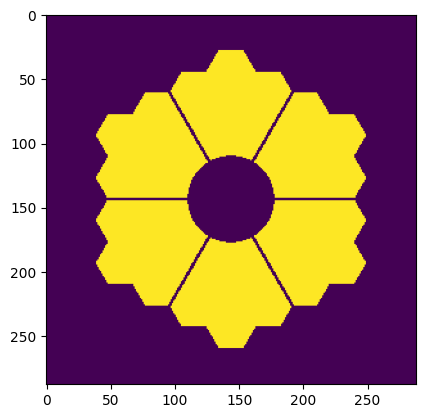

In [4]:
from OOPAO.Telescope import Telescope


sensing_wavelength  = lgsAst.src[0].wavelength           # sensing wavelength of the WFS, read from the ngs object
n_subaperture       = config_vars["nSubaperture"]        # number of subaperture across the diameter
diameter            = config_vars["diameter"]            # diameter of the support of the phase screens in [m]
resolution          = config_vars["resolution"]          # resolution of the phase screens in pixels
obs_ratio           = config_vars["centralObstruction"]  # central obstruction in fraction of the telescope diameter
sampling_time       = config_vars["samplingTime"]        # sampling time of the AO loop in [s]
fieldOfViewInArcsec = config_vars["fieldOfViewInArcsec"] # field of view of the telescope (arcsec)


tel = Telescope(diameter          = diameter,
               resolution         = resolution,
               centralObstruction = obs_ratio,
               samplingTime       = sampling_time,
               fov                = fieldOfViewInArcsec)


pupil_data = loadmat(config_vars["tel_pupil"])
pupil = pupil_data['pup'] 

tel.pupil = pupil

plt.imshow(tel.pupil)

## Atmosphere

In [38]:
from OOPAO.Atmosphere import Atmosphere

r0 = config_vars["r0"]
L0 = config_vars["L0"]

fractionnalR0 = config_vars["fractionnalR0"]
windSpeed = config_vars["windSpeed"]
windDirection = config_vars["windDirection"]
altitude = config_vars["altitude"]



atm = Atmosphere(telescope      = tel,
                 src            = lgsAst,
                 r0             = r0,
                 L0             = L0,
                 fractionalR0   = fractionnalR0,
                 altitude       = altitude,
                 windDirection  = windDirection,
                 windSpeed      = windSpeed)


atm.initializeAtmosphere(telescope=tel)

Creation of layer1/7 ...
-> Computing the initial phase screen...
initial phase screen : 0.03844022750854492 s


KeyboardInterrupt: 

In [ ]:
lgsAst**atm*tel


--------------------------------- Asterism ---------------------------------
 Source | Wavelength | Zenith | Azimuth | Altitude | Magnitude |   Flux    |
        |    [m]     |[arcsec]|   [°]   |   [m]    |           | [ph/m²/s] |
  1-NGS |  5.9e-07   |  7.60  |  0.00   |   inf    |   8.89    |  2.5e+06  |
  2-NGS |  5.9e-07   |  7.60  |  90.00  |   inf    |   8.89    |  2.5e+06  |
  3-NGS |  5.9e-07   |  7.60  | 180.00  |   inf    |   8.89    |  2.5e+06  |
  4-NGS |  5.9e-07   |  7.60  | 270.00  |   inf    |   8.89    |  2.5e+06  |
----------------------------------------------------------------------------

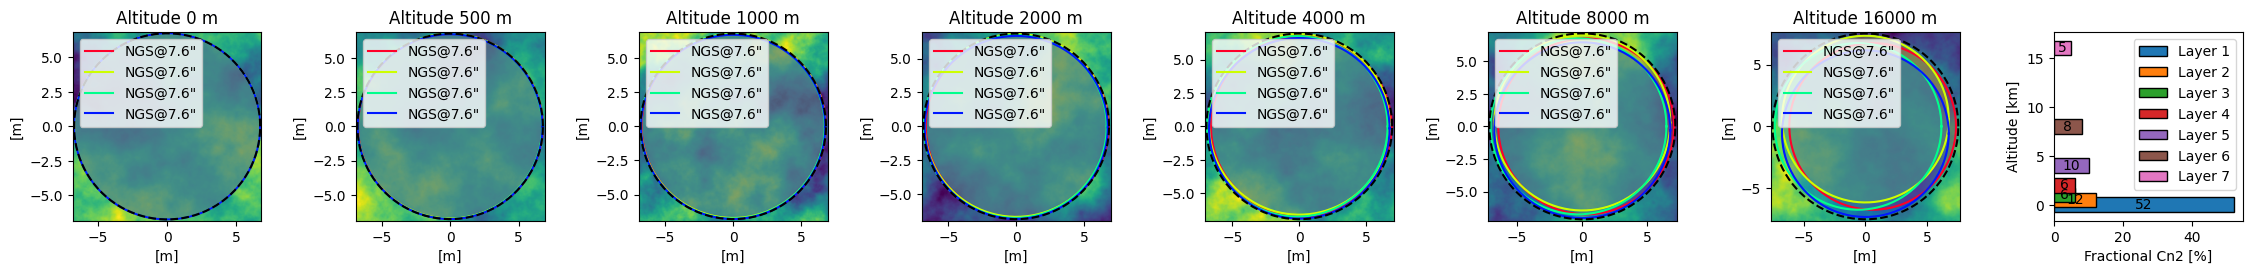

In [10]:
atm.display_atm_layers()

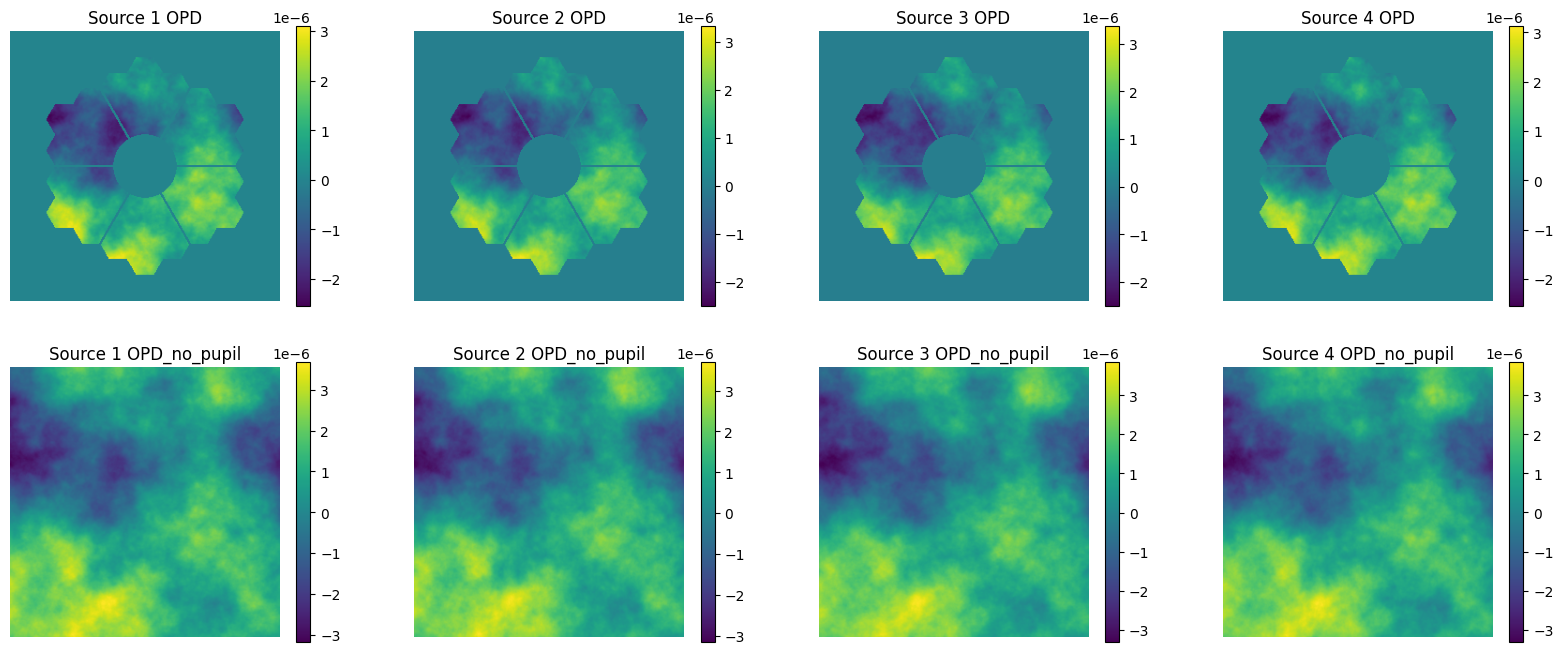

In [12]:
fig, axes = plt.subplots(2, n_lgs, figsize=(20, 8))

for i in range(n_lgs):
    im = axes[0, i].imshow(lgsAst.OPD[i])
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Source {i+1} OPD')
    fig.colorbar(im, ax=axes[0, i])

    im = axes[1, i].imshow(lgsAst.OPD_no_pupil[i])
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Source {i+1} OPD_no_pupil')
    fig.colorbar(im, ax=axes[1, i])


## ShackHartmann WFS

In [13]:
from OOPAO.ShackHartmann import ShackHartmann

shwfs = ShackHartmann(telescope          = tel,
                      nSubap             = n_subaperture,
                      lightRatio         = 0.5,
                      is_geometric       = False,
                      shannon_sampling   = True,
                      threshold_cog      = 0.01)


shwfs_geom = ShackHartmann(telescope     = tel,
                    nSubap             = n_subaperture,
                    lightRatio         = 0.5,
                    is_geometric       = True,
                    shannon_sampling   = True,
                    threshold_cog      = 0.01)



No user-input pixel scale - using shannon_sampling input value:2 pixel(s) per spot FWHM
-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   288   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Selecting valid subapertures based on flux considerations..
Acquiring reference slopes..
updating the flux of the SHWFS object
Done!
Recalibrating the slopes units
Acquiring reference slopes..
Done!
Done

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   24    
Subaperture Pitch [m]    |  0.56   
Subaperture FoV [arcsec] |  1.30   
Pixel Scale [arcsec]     |  0.108  
Valid Subapertures       |   456   
Spot Sampling [pix]      |  2.00   
Geometric WFS            |  False  
----------------------

In [17]:
unfiltered_subap_mask = np.loadtxt(config_vars["unfiltered_subap_mask"], dtype=bool, delimiter=",")
filtered_subap_mask = np.loadtxt(config_vars["filtered_subap_mask"], dtype=bool, delimiter=",")

shwfs.valid_subapertures = unfiltered_subap_mask.copy()
shwfs.valid_slopes_maps[:24, :] = unfiltered_subap_mask.copy()
shwfs.valid_slopes_maps[24:, :] = unfiltered_subap_mask.copy()
shwfs.nValidSubaperture = np.count_nonzero(shwfs.valid_subapertures)

shwfs.filtered_subap_mask = filtered_subap_mask.copy()
shwfs.unfiltered_subap_mask = unfiltered_subap_mask.copy()

shwfs_geom.valid_subapertures = unfiltered_subap_mask.copy()
shwfs_geom.valid_slopes_maps[:24, :] = unfiltered_subap_mask.copy()
shwfs_geom.valid_slopes_maps[24:, :] = unfiltered_subap_mask.copy()
shwfs_geom.nValidSubaperture = np.count_nonzero(shwfs_geom.valid_subapertures)

shwfs_geom.filtered_subap_mask = filtered_subap_mask.copy()
shwfs_geom.unfiltered_subap_mask = unfiltered_subap_mask.copy()


NGS(Na) ~~> atmosphere ~~> telescope ~~> shackHartmann
NGS(Na) ~~> atmosphere ~~> telescope ~~> shackHartmann
NGS(Na) ~~> atmosphere ~~> telescope ~~> shackHartmann
NGS(Na) ~~> atmosphere ~~> telescope ~~> shackHartmann


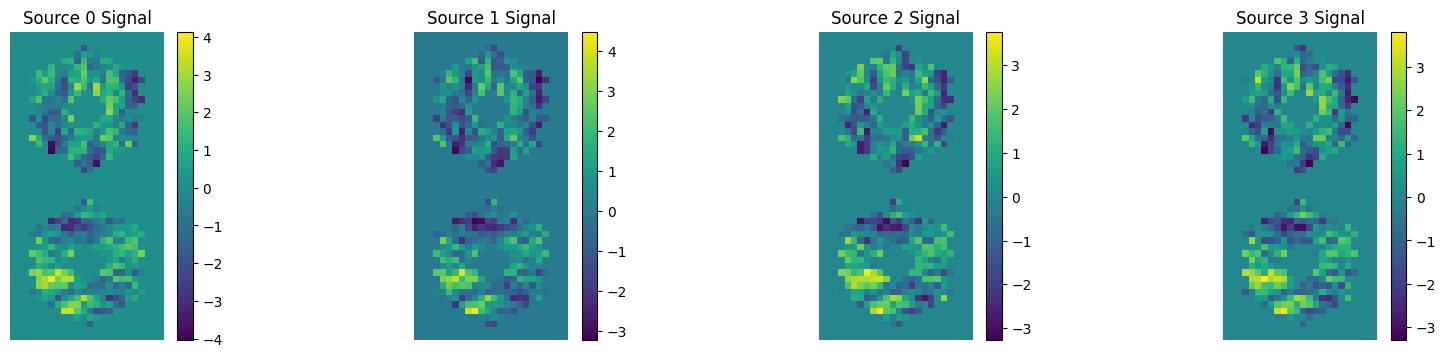

In [18]:
lgsAst**atm*tel*shwfs

lgsAst.print_optical_path()

fig, axes = plt.subplots(1, n_lgs, figsize=(20, 4))

for i in range(n_lgs):
    im = axes[i].imshow(shwfs.signal_2D[i])
    axes[i].axis('off')
    axes[i].set_title(f'Source {i} Signal')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)


## Deformable Mirror

In [19]:
from OOPAO.DeformableMirror import DeformableMirror
from OOPAO.MisRegistration import MisRegistration


mechanical_coupling = config_vars['mechanicalCoupling']
misReg = MisRegistration(config_vars)

unfiltered_act_mask = np.loadtxt(config_vars["actuator_mask"], dtype=bool, delimiter=",")
if unfiltered_act_mask.shape[0] != config_vars['nActuator']:
    unfiltered_act_mask = np.pad(unfiltered_act_mask, pad_width=int(config_vars['nSubapExtra']/2), mode='constant', constant_values=0)


X, Y = tomoAO.tools.tomography_tools.meshgrid(config_vars['nActuator'], tel.D, offset_x=0.0, offset_y=0.0, stretch_x=1, stretch_y=1)
coordinates = np.array([X[unfiltered_act_mask], Y[unfiltered_act_mask]]).T

dm = DeformableMirror(telescope=tel,
                            nSubap=config_vars['nSubaperture'],
                            mechCoupling=config_vars['mechanicalCoupling'],
                            misReg=misReg,
                            coordinates=coordinates,
                            pitch=tel.D / (config_vars['nActuator'] - 1))


dm.unfiltered_act_mask = unfiltered_act_mask.copy()


Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   349   
M4                       |  False  
Pitch [m]                |  0.56   
Mechnical coupling [%]   |   15    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------



### AO System (tomoAO)


In [20]:
aoSys = tomoAO.Simulation.AOSystem(config_vars, tel=tel, lgsAst=lgsAst, dm=dm, atm=atm, wfs=shwfs)


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 9.0e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 2.2e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 1.9e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------

Coordinates loaded...
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   349   
M4                       |  False  
Pitch [m]                |  0.56   
Mechnical coupling [%]   |   15    
== Misregistra

### Tomographic Reconstructor (tomoAO)


In [21]:
from tomoAO.Reconstruction.reconClassType import tomoReconstructor

rec = tomoReconstructor(aoSys=aoSys, alpha=10, os=2, 
                        order=config_vars["order"], indexation=config_vars["indexation"])


atm.r0 = 0.16


Updating the Atmosphere covariance matrices...
GPU not available, using CPU
Building Gamma
Took 0.06177234649658203 seconds to build Gamma
Building the covariance matrices
Took 40.09795546531677 seconds to build the covariance matrices
Building the reconstructor
Took 3.4584145545959473 seconds to build the reconstructor
Updating the Atmosphere covariance matrices...


In [25]:
reconstructor = rec.reconstructor.copy()

### Loop

-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |  1152   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 1.7e-06 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 2.9e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------



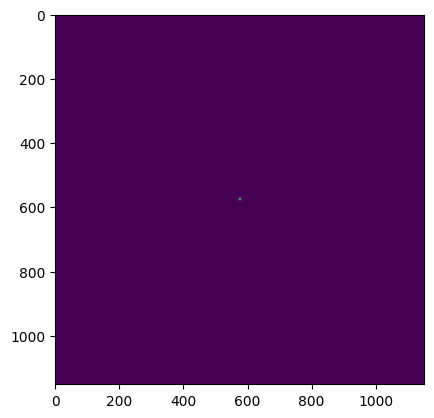


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.9e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  0.00   
Flux [photon/m²/s]       | 9.0e+09 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------



  1%|          | 4/349 [00:00<00:09, 36.63it/s]

updating the flux of the SHWFS object


100%|██████████| 349/349 [00:09<00:00, 36.17it/s]

Running closed loop with diffractive sensor


In [22]:
from OOPAO.Detector import Detector
SciSrc_cam = Detector(tel.resolution*4)
SciSrc_cam.psf_sampling = 4
SciSrc_cam.integrationTime = tel.samplingTime*1


# Define a scientific source:
SciSrc = Source(optBand='H', magnitude=0)

dm.coefs = 0      # initialize DM commands

# initialize DM commands
SciSrc**atm*tel*dm*SciSrc_cam


nLoop = config_vars["nLoop"]

# allocate memory to save data
SR                      = np.zeros(nLoop)
total                   = np.zeros(nLoop)
residual                = np.zeros(nLoop)
wfsSignal               = np.arange(0,shwfs.nSignal*n_lgs)*0

# loop parameters
gainCL                  = config_vars["gainCL"]

atm.generateNewPhaseScreen(10)
# Save reference frame 
SciSrc**tel*dm*SciSrc_cam
plt.imshow(SciSrc_cam.frame)
plt.show()
SciSrc_cam.reference_frame = SciSrc_cam.frame.copy()



from tqdm import tqdm

if config_vars["loop_mode"] == 'closed':
    calib_src = Source('Na', 0)

    calib_src**atm
    dm_eye = np.eye(dm.nValidAct)
    imat = np.zeros((shwfs_geom.nValidSubaperture*2, dm.nValidAct)) 
    for i_act in tqdm(range(dm.nValidAct)):
        dm.coefs = dm_eye[:, i_act]*calib_src.wavelength/2/np.pi
        calib_src**tel*dm*shwfs_geom
        
        wfsSignal = np.hstack(shwfs_geom.signal)
        
        if rec.indexation == "xyxy":
            wfsSignal_xyxy = np.zeros(wfsSignal.shape)
            wfsSignal_xyxy[::2] = wfsSignal[:int(len(wfsSignal)/2)]
            wfsSignal_xyxy[1::2] = wfsSignal[int(len(wfsSignal)/2):]
            wfsSignal = wfsSignal_xyxy.copy()
            
        
        imat[:, i_act] = wfsSignal

    imat = imat*2*np.pi/calib_src.wavelength    
    imat = np.vstack([imat]*n_lgs)


print(f"Running {config_vars['loop_mode']} loop with {'geometric' if config_vars['wfs_type'] == 'g' else 'diffractive'} sensor")


In [26]:


for i in range(nLoop):

    atm.update()
    SciSrc**atm*tel

    total[i]=np.std(SciSrc.OPD[np.where(tel.pupil>0)])*1e9


    if config_vars["loop_mode"] == 'open':
        lgsAst**atm*tel*shwfs_geom*dm
        wfsSignal = np.hstack(shwfs_geom.signal)
        
    elif config_vars["loop_mode"] == 'closed':

        if config_vars["wfs_type"] == 'g':
            lgsAst**atm*tel*dm*shwfs_geom
            wfsSignal = np.hstack(shwfs_geom.signal)

        elif config_vars["wfs_type"] == 'd':
            lgsAst**atm*tel*dm*shwfs
            wfsSignal = np.hstack(shwfs.signal)
    
    

    if rec.indexation == "xyxy":

        wfsSignal_xyxy = np.zeros(wfsSignal.shape)
        wfsSignal_xyxy[::2] = wfsSignal[:int(len(wfsSignal)/2)]
        wfsSignal_xyxy[1::2] = wfsSignal[int(len(wfsSignal)/2):]
        wfsSignal = wfsSignal_xyxy.copy()


    if config_vars["loop_mode"] == 'closed':
        wfsSignal = wfsSignal-imat@dm.coefs

    SciSrc**atm*tel*dm*SciSrc_cam

    dm.coefs = (1-gainCL)*dm.coefs - gainCL * (reconstructor@wfsSignal)

    SR[i]=np.exp(-np.var(SciSrc.phase[np.where(tel.pupil==1)]))
    residual[i] = np.sqrt(np.var(SciSrc.OPD[np.where(SciSrc.mask==1)])) * 1e9

    
    print('Loop'+str(i)+'/'+str(nLoop)+' AO residual: '+str(residual[i])+' nm')


Loop0/1000 AO residual: 1109.9124052203563 nm
Loop1/1000 AO residual: 264.6039905013402 nm
Loop2/1000 AO residual: 147.6940653097354 nm
Loop3/1000 AO residual: 151.69922325670694 nm
Loop4/1000 AO residual: 149.16013186853064 nm
Loop5/1000 AO residual: 145.10146676924595 nm
Loop6/1000 AO residual: 143.44956098641444 nm
Loop7/1000 AO residual: 145.26783507073728 nm
Loop8/1000 AO residual: 144.10268251381734 nm
Loop9/1000 AO residual: 142.93139707778843 nm
Loop10/1000 AO residual: 140.02500898283185 nm
Loop11/1000 AO residual: 138.39079612186762 nm
Loop12/1000 AO residual: 137.67641468395627 nm
Loop13/1000 AO residual: 135.5302314435256 nm
Loop14/1000 AO residual: 135.96904735901035 nm
Loop15/1000 AO residual: 139.26652547182093 nm
Loop16/1000 AO residual: 146.57647581640984 nm
Loop17/1000 AO residual: 149.9765824442752 nm
Loop18/1000 AO residual: 147.82216256665262 nm
Loop19/1000 AO residual: 146.09946743647333 nm
Loop20/1000 AO residual: 146.08455858731836 nm
Loop21/1000 AO residual: 14

## Results

In [34]:
print(f"Mean AO res {round(np.mean(residual[50:]), 2)} nm")
print(f"Mean Marechal SR: {round(np.mean(SR[50:])*100, 2)}%")
print(f"max(i_ao)/max(i_dl) SR: {round(np.max(SciSrc_cam.frame)/np.max(SciSrc_cam.reference_frame)*100, 2)}%")


Mean AO res 150.48 nm
Mean Marechal SR: 72.1%
max(i_ao)/max(i_dl) SR: 74.37%


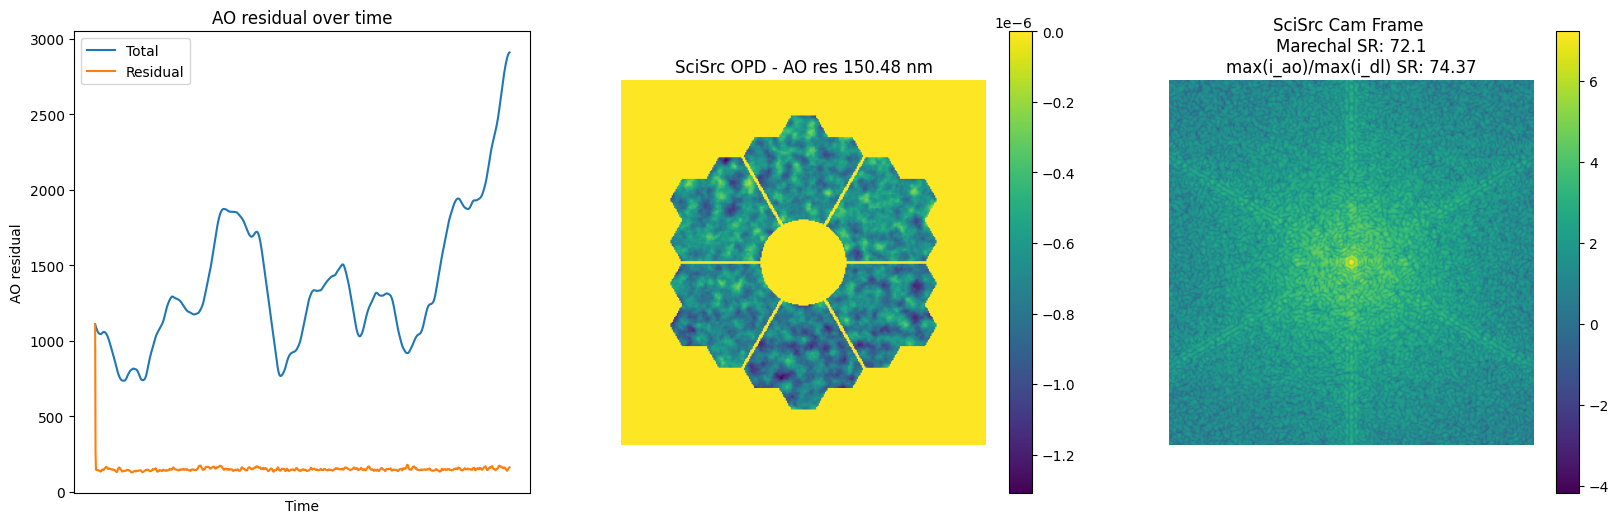

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

axes[0].plot(total, label="Total")
axes[0].plot(residual, label="Residual")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("AO residual")
axes[0].set_title("AO residual over time")
axes[0].legend()
axes[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


im = axes[1].imshow(SciSrc.OPD)
axes[1].axis('off')
axes[1].set_title(f"SciSrc OPD - AO res {round(np.mean(residual[50:]), 2)} nm")
fig.colorbar(im, ax=axes[1])


# set back the reflectivity 1
tel.pupilReflectivity = tel.pupil.astype(float)

SciSrc**atm*tel*dm 

# compute PSF method
zeroPaddingFactor = 6
tel.computePSF(zeroPaddingFactor=zeroPaddingFactor, detector=SciSrc_cam)

# get current pixel scale
size_pixel_arcsec = 206265*(tel.src.wavelength/tel.D)/zeroPaddingFactor
N                 = 250
normalized_PSF    = tel.PSF[N:-N,N:-N]# crop to zoom on the center
fov               = normalized_PSF.shape[0]*size_pixel_arcsec # get the corresponding fov


im = axes[2].imshow(np.log10(normalized_PSF),extent=[-fov/2,fov/2,-fov/2,fov/2])
axes[2].axis('off')
axes[2].set_title(f"SciSrc Cam Frame \nMarechal SR: {round(np.mean(SR[50:])*100, 2)}\nmax(i_ao)/max(i_dl) SR: {round(np.max(SciSrc_cam.frame)/np.max(SciSrc_cam.reference_frame)*100, 2)}")
fig.colorbar(im, ax=axes[2])

